# 5 GLMの尤度比検定と検定の非対称性

In [1]:
using CSV
using Distributions
using GLM
using Plots
using StatsBase
using Statistics

In [2]:
df = CSV.read("data3a.csv");

### 5.4.1 方法(1) 汎用性のあるパラメトリックブートストラップ法
一定モデル

In [3]:
fit1 = glm(@formula(y ~ 1), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ +1

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)   2.05796 0.0357371 57.5862   <1e-99


xモデル

In [4]:
fit2 = glm(@formula(y ~ x), df, Poisson())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.29172  0.363686 3.55174   0.0004
x            0.0756619 0.0356042 2.12509   0.0336


### 残差逸脱度の差

In [5]:
deviance(fit1) - deviance(fit2)

4.513941078851829

### 真のモデルから100個体分のデータを新しく生成

In [6]:
df.y_rnd = rand(Poisson(mean(df.y)), 100)

100-element Array{Int64,1}:
 10
  7
  9
  6
  8
  6
  5
 12
  8
  6
  8
  8
 11
  ⋮
  8
  3
  6
  5
  4
  6
  8
  9
  7
 11
  9
  9

### 一定モデルとxモデルをこの真データに当てはめる

In [7]:
fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
deviance(fit1) - deviance(fit2)

1.3429940882300144

### PB法を実行する関数
データの生成と逸脱度差の評価

In [8]:
function get_dd(df)
    n_samples = size(df, 1)
    y_mean = mean(df.y)
    df.y_rnd = rand(Poisson(y_mean), n_samples)
    fit1 = glm(@formula(y_rnd ~ 1), df, Poisson())
    fit2 = glm(@formula(y_rnd ~ x), df, Poisson())
    deviance(fit1) - deviance(fit2)
end

get_dd (generic function with 1 method)

In [9]:
function pb(df, n_bootstrap)
    [get_dd(df) for _ in 1:n_bootstrap]
end

pb (generic function with 1 method)

### 逸脱度の差のサンプルを1000個を作成

In [10]:
dd12 = pb(df, 1000)

1000-element Array{Float64,1}:
 0.0401696026361833   
 1.5070617728257076   
 0.2856369535353309   
 0.007809335917997373 
 1.9259449280372678   
 0.7456275073599272   
 0.23202398097875232  
 0.06073637433526358  
 0.7313564121601104   
 0.9365406635862854   
 3.309899384187773    
 0.27262762635172066  
 0.4611197488120098   
 ⋮                    
 0.16735788324501755  
 1.4246380478989806   
 0.8827725900923156   
 3.869532771373315    
 0.018158444199968926 
 0.28480773009005134  
 1.0698633107784445   
 0.0016949001433772537
 0.9101275956259514   
 0.8232468445648493   
 0.14872044911938076  
 0.01677196644025969  

In [11]:
describe(dd12)

Summary Stats:
Mean:           1.004756
Minimum:        0.000000
1st Quartile:   0.097193
Median:         0.429462
3rd Quartile:   1.288192
Maximum:        15.368768
Length:         1000
Type:           Float64


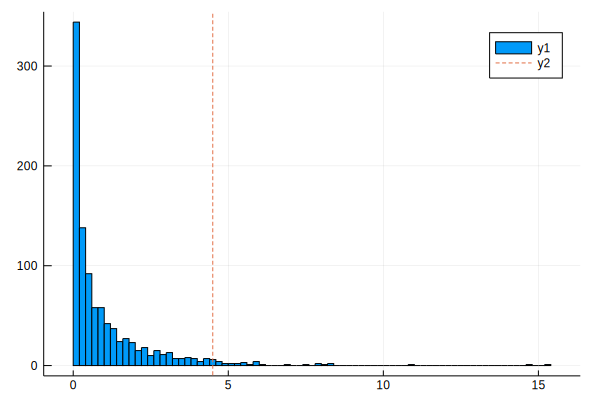

In [12]:
histogram(dd12, bins=100)
plot!([4.5], seriestype=:vline, linestyle=:dash)

合計1000個の$\Delta D_{1,2}$のうちいくつが4.5より右にあるか

In [13]:
sum(dd12 .>= 4.5)

33

$P=0.05$となる逸脱度の差

In [14]:
quantile(dd12, 0.95)

3.9070529549370105

### 方法(2) $\chi^2$分布を使った近似計算法

In [15]:
ccdf(Chisq(1), 4.513)

0.03363819191961954